In [2]:
# # HINT SMALL DRUG BASELINES
# # Phase I
# PR-AUC   mean: 0.6030 std: 0.0132
# F1       mean: 0.5798 std: 0.0159
# ROC-AUC  mean: 0.5706 std: 0.0181

# # Phase II
# PR-AUC   mean: 0.5798 std: 0.0112
# F1       mean: 0.5653 std: 0.0125
# ROC-AUC  mean: 0.5821 std: 0.0106

# # Phase III
# PR-AUC   mean: 0.7338 std: 0.0090
# F1       mean: 0.7922 std: 0.0070
# ROC-AUC  mean: 0.6916 std: 0.0144
# ACC  mean: 0.6955 std: 0.0089

In [1]:
## =========== model results visualization ===========
import numpy as np
import pickle 
import sklearn.metrics
import sklearn
import sklearn.linear_model
import sklearn.ensemble
import sklearn.tree
import matplotlib.pyplot as plt
import scipy

def parse_icd(icd):
    if icd[:4] == 'None': return "None"
    try:
        c = icd[0]
        if icd[2].isalpha(): num = int(icd[1:2]) * 10
        else: num = int(icd[1:3])
    except:
        print(icd)    
    if c in ['A', 'B']: return "Certain infections and parasitic diseases"
    elif c in ['C']: return "Neoplasms"
    elif c in ['D']:
        if num <= 49: return "Neoplasms"
        else: return "Diseases of the blood and blood-forming organs and certain disorders involving the immune mechanism"
    elif c in ['E']: return "Endocrine, nutritional and metabolic diseases"
    elif c in ['F']: return "Mental, Behavioral and Neurodevelopmental disorders"
    elif c in ['G']: return "Diseases of the nervous system"
    elif c in ['H']: 
        if num <= 59: return "Diseases of the eye and adnexa" 
        else: return "Diseases of the ear and mastoid process"
    elif c in ['I']: return "Diseases of the circulatory system"
    elif c in ['J']: return "Diseases of the respiratory system"
    elif c in ['K']: return "Diseases of the digestive system"
    elif c in ['L']: return "Diseases of the skin and subcutaneous tissue"
    elif c in ['M']: return "Diseases of the musculoskeletal system and connective tissue"
    elif c in ['N']: return "Diseases of the genitourinary system"
    elif c in ['O']: return "Pregnancy, childbirth, and puerperium"
    elif c in ['P']: return "Certain conditions originating in the perinatal period"
    elif c in ['Q']: return "Congenital malformations, deformations and chromosomal abnormalities"
    elif c in ['R']: return "Symptoms, signs, and abnormal clinical laboratory findings, not elsewhere classified"
    elif c in ['S', 'T']: return "Injury, poisoning, and certain other consequences of external causes"
    elif c in ['U']: return "Codes for special purposes" # shouldn't be used
    elif c in ['V', 'W', 'X', 'Y']: return "External causes of morbidity" 
    elif c in ['Z']: return "Factors influencing health status and contact with health services" #c in ['Z']: 
    else: return "None"

def parse_top_level_icd10(icds):
    # assumes inputs is list of list of icds
    assert len(icds) > 0
    assert type(icds[0]) is list
    all_icds = []
    for icds_ in icds: all_icds.extend(icds_)

    return list(set([parse_icd(icd) for icd in all_icds]))

def bootstrap_eval_(labels, preds):
    prauc = sklearn.metrics.average_precision_score(y_true=labels, y_score=preds[:,1])
    if len(np.unique(labels)) > 1:
        rocauc = sklearn.metrics.roc_auc_score(y_true=labels, y_score=preds[:,1])
    else:
        rocauc = np.nan
    f1 = sklearn.metrics.f1_score(y_true=labels, y_pred=preds.argmax(axis=1))
    acc = sklearn.metrics.accuracy_score(y_true=labels, y_pred=preds.argmax(axis=1))
    return prauc, rocauc, f1, acc
    
def bootstrap_eval(labels, preds, n_bootstrap=20, random_state=0):
    prauc_list = []
    rocauc_list = []
    f1_list = []
    acc_list = []

    np.random.seed(seed=random_state)
    for i in range(n_bootstrap):
        bootstrap_inds = np.random.randint(0, len(labels), size=len(labels))
        prauc, rocauc, f1, acc = bootstrap_eval_(labels=labels[bootstrap_inds], preds=preds[bootstrap_inds])
        prauc_list.append(prauc)
        rocauc_list.append(rocauc)
        f1_list.append(f1)
        acc_list.append(acc)

    return np.nan_to_num(np.nanmean(prauc_list)), np.nan_to_num(np.nanstd(prauc_list)), \
        np.nan_to_num(np.nanmean(rocauc_list)), np.nan_to_num(np.nanstd(rocauc_list)), \
        np.nan_to_num(np.nanmean(f1_list)), np.nan_to_num(np.nanstd(f1_list)), \
        np.nan_to_num(np.nanmean(acc_list)), np.nan_to_num(np.nanstd(acc_list))

def run_baselines(train_x, train_y, test_x, test_y, random_state=1, prepend=''):
    # logistic regression, svm, adaboost, xgboost, decision tree
    # baselines_csv = ['Model, Test PR AUC, Test ROC AUC, Test F1, Test Acc.']
    baselines_csv = []
    model_names = ['Logistic Regression', 'SVM', 'Decision Tree', 'AdaBoost', 'Random Forest']
    models = [sklearn.linear_model.LogisticRegression(random_state=random_state),
        sklearn.svm.SVC(random_state=random_state, kernel='linear', probability=True), 
        sklearn.tree.DecisionTreeClassifier(random_state=random_state),
        sklearn.ensemble.AdaBoostClassifier(random_state=random_state),
        sklearn.ensemble.RandomForestClassifier(random_state=random_state, n_estimators=10)]

    for i in range(len(models)):
        preds = models[i].fit(train_x, train_y).predict_proba(test_x)
        prauc, prauc_std, rocauc, rocauc_std, f1, f1_std, acc, acc_std = bootstrap_eval(labels=test_y, preds=preds)
        baselines_csv.append(prepend+"{}, {:.3f} $\pm$ {:.3f}, {:.3f} $\pm$ {:.3f}, {:.3f} $\pm$ {:.3f}, {:.3f} $\pm$ {:.3f}".format(\
            model_names[i], prauc, prauc_std, rocauc, rocauc_std, f1, f1_std, acc, acc_std))

    return baselines_csv

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9] [8, 25, 10, 21, 27, 24, 46, 108, 96, 1]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9] [0, 0, 77, 135, 167, 198, 314, 492, 904, 101]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9] [0, 35, 140, 162, 160, 218, 279, 455, 943, 227]
Mode, Model, Test PR AUC, Test ROC AUC, Test F1, Test Acc.


Mode, Phase, Train PR AUC, Train ROC AUC, Train F1, Train Acc.
bio, 1, 0.928 $\pm$ 0.013, 0.851 $\pm$ 0.016, 0.859 $\pm$ 0.013, 0.804 $\pm$ 0.017
bio, 2, 0.868 $\pm$ 0.012, 0.809 $\pm$ 0.014, 0.764 $\pm$ 0.012, 0.723 $\pm$ 0.013
bio, 3, 0.957 $\pm$ 0.010, 0.883 $\pm$ 0.018, 0.911 $\pm$ 0.010, 0.862 $\pm$ 0.015
drugs, 1, 0.791 $\pm$ 0.014, 0.741 $\pm$ 0.012, 0.762 $\pm$ 0.011, 0.695 $\pm$ 0.011
drugs, 2, 0.722 $\pm$ 0.011, 0.727 $\pm$ 0.007, 0.676 $\pm$ 0.007, 0.638 $\pm$ 0.006
drugs, 3, 0.873 $\pm$ 0.006, 0.794 $\pm$ 0.006, 0.819 $\pm$ 0.006, 0.733 $\pm$ 0.007
both, 1, 0.845 $\pm$ 0.009, 0.774 $\pm$ 0.008, 0.785 $\pm$ 0.008, 0.725 $\pm$ 0.008
both, 2, 0.727 $\pm$ 0.009, 

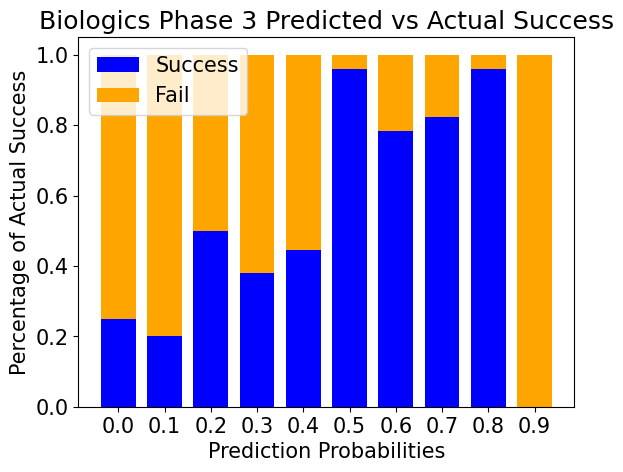

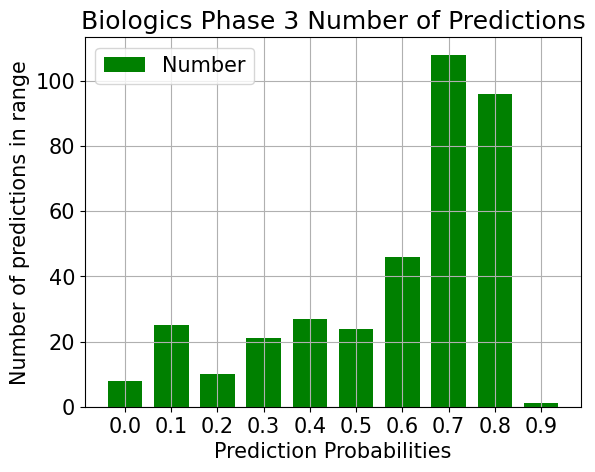

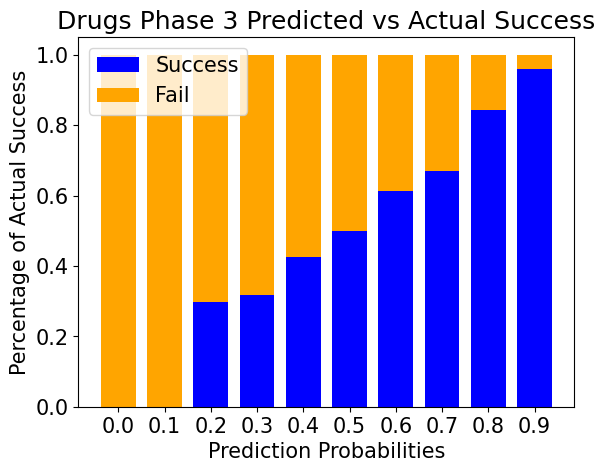

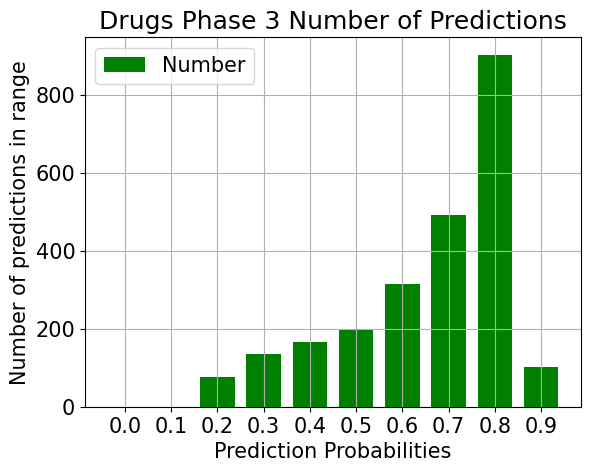

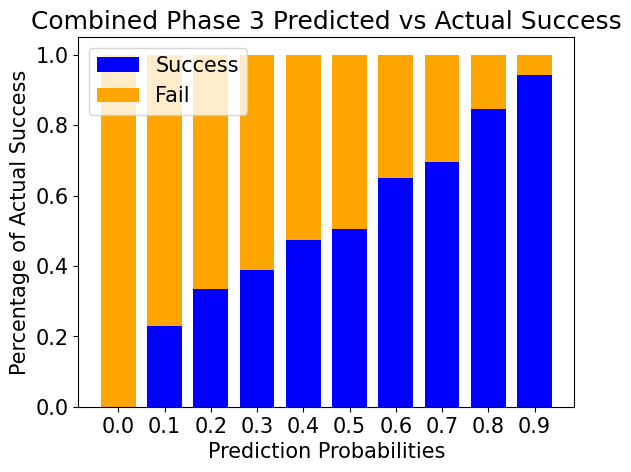

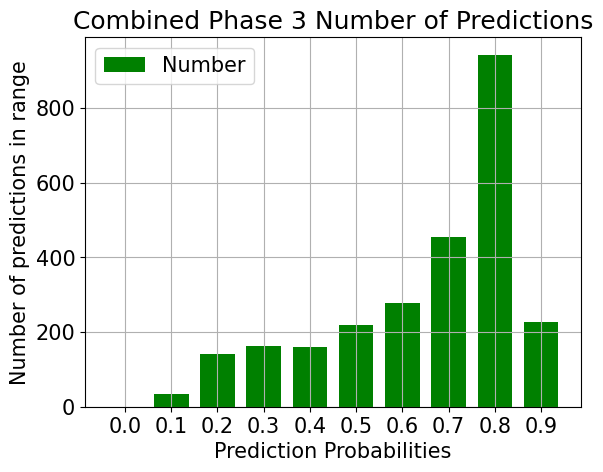

In [2]:
save_path = './test_results_f1_2/'
# save_path = './test_results_roc/'
test_metrics_csv = ['Mode, Phase, Test PR AUC, Test ROC AUC, Test F1, Test Acc.']
train_metrics_csv = ['Mode, Phase, Train PR AUC, Train ROC AUC, Train F1, Train Acc.']
baselines_metrics_csv = ['Mode, Model, Test PR AUC, Test ROC AUC, Test F1, Test Acc.']
disease_metrics_csv = ['Mode\tPhase\tCategory\tN (% Pos.)\tTest PR AUC\tTest ROC AUC\tTest F1\tTest Acc.']

for train_mode in ['bio', 'drugs', 'both']:
    for phase in ['1','2','3']:
# for train_mode in ['bio',]:
#     for phase in ['3']:

        all_valid_trials = pickle.load(open('all_valid_trials2.pkl', 'rb'))
        # print('len all valid files:', len(all_valid_trials))
        if train_mode == 'bio':
            all_valid_trials = [trial for trial in all_valid_trials 
                if 'phase '+phase in trial['phase'].lower() and 'Biological' in trial['intervention_types']
            ]
        elif train_mode == 'drugs':
            all_valid_trials = [trial for trial in all_valid_trials 
                if 'phase '+phase in trial['phase'].lower() and 'Drug' in trial['intervention_types']
            ]
        else: # args.train_mode == 'both
            all_valid_trials = [trial for trial in all_valid_trials 
                if 'phase '+phase in trial['phase'].lower()
            ]

        years = [trial['start_date'] for trial in all_valid_trials]

        year2split = 2015-1970 # convert to standard unix time
        test_trials = [trial for trial in all_valid_trials if trial['completion_date'] >= year2split]
        train_trials = [trial for trial in all_valid_trials if trial['completion_date'] < year2split]

        train_labels = np.array([trial['label'] for trial in train_trials])
        train_preds = np.load(save_path+'phase_{}_mode_{}_valid_output.npy'.format(phase, train_mode))
        test_labels = np.array([trial['label'] for trial in test_trials])
        test_preds = np.load(save_path+'phase_{}_mode_{}_test_output.npy'.format(phase, train_mode))
        train_preds = scipy.special.softmax(train_preds, axis=1)
        test_preds = scipy.special.softmax(test_preds, axis=1)
        ## ========== Metrics ==========
        # print(bootstrap_eval_(labels=train_labels, preds=train_preds))
        prauc, prauc_std, rocauc, rocauc_std, f1, f1_std, acc, acc_std = bootstrap_eval(labels=train_labels, preds=train_preds)
        train_metrics_csv.append("{}, {}, {:.3f} $\pm$ {:.3f}, {:.3f} $\pm$ {:.3f}, {:.3f} $\pm$ {:.3f}, {:.3f} $\pm$ {:.3f}".format(\
            train_mode, phase, prauc, prauc_std, rocauc, rocauc_std, f1, f1_std, acc, acc_std))

        # print(bootstrap_eval_(labels=test_labels, preds=test_preds))
        prauc, prauc_std, rocauc, rocauc_std, f1, f1_std, acc, acc_std = bootstrap_eval(labels=test_labels, preds=test_preds)
        test_metrics_csv.append("{}, {}, {:.3f} $\pm$ {:.3f}, {:.3f} $\pm$ {:.3f}, {:.3f} $\pm$ {:.3f}, {:.3f} $\pm$ {:.3f}".format(\
            train_mode, phase, prauc, prauc_std, rocauc, rocauc_std, f1, f1_std, acc, acc_std))


        ## ========== plot of predicted success vs actual success ==========
        if phase=='3':
            # test_preds_proba = scipy.special.softmax(test_preds, axis=1)
            threshs = np.arange(0,1,step=.1)
            rel_success = []
            for thresh in threshs:
                probs = test_labels[(thresh < test_preds[:,1]) & (test_preds[:,1] <= thresh+0.1)]
                rel_success.append(probs.sum() / len(probs) if len(probs)>0 else 0)
            rel_success = np.nan_to_num(rel_success, 0)

            if train_mode == 'bio': train_mode_name = "Biologics"
            elif train_mode == 'drugs': train_mode_name = "Drugs"
            else: train_mode_name = "Combined"
            title = "{} Phase {} Predicted vs Actual Success".format(train_mode_name, phase)
            plt.figure(); plt.clf(); plt.rcParams.update({'font.size': 15})
            plt.bar(threshs, rel_success, color='blue', width=.075, label='Success')
            plt.bar(threshs, 1.-rel_success, bottom=rel_success, color='orange', width=.075, label='Fail')
            plt.title(title); plt.xticks(threshs); plt.xlabel('Prediction Probabilities'); plt.ylabel('Percentage of Actual Success')
            plt.legend(loc='upper left'); plt.savefig('test_imgs/'+title+'.pdf')

            ## ========== plot of number of preds ==========
            num_preds = []
            for thresh in threshs:
                # probs = test_labels[(thresh < test_preds[:,1]) & (test_preds[:,1] <= thresh+0.1)]
                probs = (thresh < test_preds[:,1]) & (test_preds[:,1] <= thresh+0.1)
                num_preds.append(probs.sum())

            plt.figure(); plt.clf(); plt.rcParams.update({'font.size': 15}); plt.grid()
            plt.bar(threshs, num_preds, color='green', width=.075, label='Number')
            # print(threshs, num_preds)
            title = "{} Phase {} Number of Predictions".format(train_mode_name, phase)
            plt.title(title); plt.xticks(threshs); plt.xlabel('Prediction Probabilities'); plt.ylabel('Number of predictions in range'); 
            plt.legend(loc='upper left'); plt.savefig('test_imgs/'+title+'.pdf')

        # ## ========== plot baselines results on drug and bio ==========
        # if phase=='3' and train_mode=='bio':
        #     train_x, train_y, test_x, test_y = pickle.load(open('phase_{}_mode_{}_linear_data.pkl'.format(phase, train_mode), 'rb'))
        #     print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)
        #     bio_linear_baselines = run_baselines(train_x, train_y, test_x, test_y, prepend="bio, ")
        #     baselines_metrics_csv.extend(bio_linear_baselines)
        #     baselines_metrics_csv.append("{}, {}, {:.3f} $\pm$ {:.3f}, {:.3f} $\pm$ {:.3f}, {:.3f} $\pm$ {:.3f}, {:.3f} $\pm$ {:.3f}".format(\
        #         train_mode, "LINT", prauc, prauc_std, rocauc, rocauc_std, f1, f1_std, acc, acc_std))

        # if phase=='3' and train_mode=='drugs':
        #     train_x, train_y, test_x, test_y = pickle.load(open('phase_{}_mode_{}_linear_data.pkl'.format(phase, train_mode), 'rb'))
        #     print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)
        #     drug_linear_baselines = run_baselines(train_x, train_y, test_x, test_y, prepend="drugs, ")
        #     baselines_metrics_csv.extend(drug_linear_baselines)
        #     baselines_metrics_csv.append("{}, {}, {:.3f} $\pm$ {:.3f}, {:.3f} $\pm$ {:.3f}, {:.3f} $\pm$ {:.3f}, {:.3f} $\pm$ {:.3f}".format(\
        #         train_mode, "LINT", prauc, prauc_std, rocauc, rocauc_std, f1, f1_std, acc, acc_std))

        # if phase=='3' and train_mode=='both':
        #     train_x1, train_y1, test_x1, test_y1 = pickle.load(open('phase_{}_mode_bio_linear_data.pkl'.format(phase, train_mode), 'rb'))
        #     train_x2, train_y2, test_x2, test_y2 = pickle.load(open('phase_{}_mode_drugs_linear_data.pkl'.format(phase, train_mode), 'rb'))
        #     train_x, train_y, test_x, test_y = np.concatenate([train_x1, train_x2]), np.concatenate([train_y1, train_y2]), np.concatenate([test_x1, test_x2]), np.concatenate([test_y1, test_y2])

        #     print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)
        #     drug_linear_baselines = run_baselines(train_x, train_y, test_x, test_y, prepend="both, ")
        #     baselines_metrics_csv.extend(drug_linear_baselines)
        #     baselines_metrics_csv.append("{}, {}, {:.3f} $\pm$ {:.3f}, {:.3f} $\pm$ {:.3f}, {:.3f} $\pm$ {:.3f}, {:.3f} $\pm$ {:.3f}".format(\
        #         train_mode, "LINT", prauc, prauc_std, rocauc, rocauc_std, f1, f1_std, acc, acc_std))

        ## ========== plot of success for each category ==========
        if phase=='3':
            test_labels = np.array(test_labels)
            icds = [parse_top_level_icd10(trial['icdcode_lst']) for trial in test_trials]
            cats = [item for sublist in icds for item in sublist]
            cats = [c for c in cats if c is not "None"] # filter out Nones
            unique_cats, counts = np.unique(cats, return_counts=True)
            # select top 10 cats in terms of frequency
            inds = np.argsort(counts)[::-1][:5]

            for cat in unique_cats[inds]:
                mask = np.array([cat in lst for lst in icds])
                test_labels_mask = test_labels[mask]
                test_preds_mask = test_preds[mask]
                prauc, prauc_std, rocauc, rocauc_std, f1, f1_std, acc, acc_std = bootstrap_eval(labels=test_labels_mask, preds=test_preds_mask)
                disease_metrics_csv.append("{}\t{}\t{}\t{} ({:.2f})\t{:.3f} $\pm$ {:.3f}\t{:.3f} $\pm$ {:.3f}\t{:.3f} $\pm$ {:.3f}\t{:.3f} $\pm$ {:.3f}".format(\
                    train_mode, phase, cat, np.sum(mask), np.sum(test_labels_mask)/len(test_labels_mask)*100, \
                    prauc, prauc_std, rocauc, rocauc_std, f1, f1_std, acc, acc_std))


print('\n'.join(baselines_metrics_csv))
print('\n')
print('\n'.join(train_metrics_csv))
print('\n')
print('\n'.join(test_metrics_csv))
print('\n')
print('\n'.join(disease_metrics_csv))

In [3]:
import numpy as np
import importlib
import model
importlib.reload(model)

save_path = './test_results_roc/'


train_trials, train_drugs, _, _, test_trials, test_drugs = model.load_data(phase='all', train_mode='all', drug_dict_path='all_drug_dict2.pkl', trials_path='all_valid_trials2.pkl', year2split=2015)
test_labels = np.array([t['label'] for t in test_trials])
test_ids = [t['id_info'] for t in test_trials]
test_preds = np.load(save_path+'phase_{}_mode_{}_test_output.npy'.format("all", "all"))

output_csv = ["Mode, Phase, PR AUC, ROC AUC, F1, Acc."]
for train_mode in ["Biological", "Drug", "all"]:
    for phase in ["1", "2", "3"]:
        
        train_trials_, train_drugs, _, _, test_trials_, test_drugs_ = model.load_data(phase=phase, train_mode=train_mode, drug_dict_path='all_drug_dict2.pkl', trials_path='all_valid_trials2.pkl', year2split=2015)

        test_preds = np.load(save_path+'phase_{}_mode_{}_test_output.npy'.format(phase, train_mode))
        test_labels = np.array([t['label'] for t in test_trials_])
        print(test_preds.shape, test_labels.shape)
        prauc, prauc_std, rocauc, rocauc_std, f1, f1_std, acc, acc_std = bootstrap_eval(labels=test_labels, preds=test_preds)

        # test_ids_ = set([t['id_info'] for t in test_trials_])
        # test_mask = np.array([id in test_ids_ for id in test_ids])
        # print(test_labels[test_mask].shape, test_preds[test_mask].shape)
        # prauc, prauc_std, rocauc, rocauc_std, f1, f1_std, acc, acc_std = bootstrap_eval(labels=test_labels[test_mask], preds=test_preds[test_mask])

        output_csv.append("{}, {}, {:.3f} $\pm$ {:.3f}, {:.3f} $\pm$ {:.3f}, {:.3f} $\pm$ {:.3f}, {:.3f} $\pm$ {:.3f}".format(\
            train_mode, phase, prauc, prauc_std, rocauc, rocauc_std, f1, f1_std, acc, acc_std))
        
print('\n'.join(output_csv))


(441, 2) (441,)
(571, 2) (571,)
(366, 2) (366,)
(1681, 2) (1681,)
(3873, 2) (3873,)


In [17]:
codes = [code for trial in test_trials for code in trial['icdcode_lst']]
codes = [code for codes_ in codes for code in codes_]
codes = [code for code in codes if code[0]=="Z"]
uniques, counts = np.unique(codes, return_counts=True)

# most common codes
inds = np.argsort(counts)[::-1][:10]
for code, count in zip(uniques[inds], counts[inds]):
    print(code, count)

Z21 81
Z83.3 63
Z86.32 57
Z71.7 45
Z11.4 45
Z85.46 35
Z80.42 35
Z12.5 35
Z15.03 35
Z14.1 24


In [4]:
import model
import pickle
import numpy as np
import pandas as pd
import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from tqdm.auto import tqdm

def tfidf_featurize(train_x, test_x, max_features=768, return_ind_to_word=False):
    countv = CountVectorizer(max_features=max_features)
    # countv = CountVectorizer()
    train_x = countv.fit_transform(train_x)
    test_x = countv.transform(test_x)

    # tfidf = TfidfTransformer()
    # train_x = tfidf.fit_transform(train_x)
    # test_x = tfidf.transform(test_x)

    if return_ind_to_word:
        ind_to_word = {v:k for k,v in countv.vocabulary_.items()}
        return train_x, test_x, ind_to_word
    else:
        return train_x, test_x

def get_linear_data(trials, drugs):
    all_x = []
    all_y = [t['label'] for t in trials]
    for i in range(len(trials)):
        all_text = [trials[i]['brief_summary']] + trials[i]['brief_summary_additional'] + trials[i]['eligibility_text']
        for drug in drugs[i]:
            all_text.extend([drug['description'], drug['pharmacodynamics'], drug['toxicity'], drug['metabolism'], drug['absorption']])
    
        for icd_code in trials[i]['icdcode_lst']:
            all_text.extend(icd_code)
        all_x.append(' '.join(all_text))
        # all_x.append(trials[i]['all_text_embeds'].numpy().mean(axis=0))

    return np.array(all_x), np.array(all_y)


save_path = 'test_results/'
img_path = 'test_imgs/'
baselines_csv = ['Mode, Phase, Model, PRAUC, ROCAUC, F1, Acc']
random_state = 1

for train_mode in tqdm(["Biological", "Drug", "all"]):
    for phase in ["3"]:

        train_trials_, train_drugs_, _, _, test_trials_, test_drugs_ = model.load_data(phase=phase, train_mode=train_mode, drug_dict_path='all_drug_dict2.pkl', trials_path='all_valid_trials2.pkl', year2split=2015)

        test_x, test_y = get_linear_data(test_trials_, test_drugs_)
        train_x, train_y = get_linear_data(train_trials_, train_drugs_)
        train_x, test_x = tfidf_featurize(train_x, test_x)

        model_names = ['Logistic Regression', 'SVM', 'Decision Tree', 'AdaBoost', 'Random Forest']
        models = [sklearn.linear_model.LogisticRegression(random_state=random_state),
            sklearn.svm.SVC(random_state=random_state, probability=True), 
            sklearn.tree.DecisionTreeClassifier(random_state=random_state),
            sklearn.ensemble.AdaBoostClassifier(random_state=random_state),
            sklearn.ensemble.RandomForestClassifier(random_state=random_state, n_estimators=10)]

        for i in range(len(models)):
            preds = models[i].fit(train_x, train_y).predict_proba(test_x)
            prauc, prauc_std, rocauc, rocauc_std, f1, f1_std, acc, acc_std = bootstrap_eval(labels=test_y, preds=preds)
            baselines_csv.append("{}, {}, {}, {:.3f} $\pm$ {:.3f}, {:.3f} $\pm$ {:.3f}, {:.3f} $\pm$ {:.3f}, {:.3f} $\pm$ {:.3f}".format(\
                train_mode, phase, model_names[i], prauc, prauc_std, rocauc, rocauc_std, f1, f1_std, acc, acc_std))




  0%|          | 0/3 [00:00<?, ?it/s]

In [11]:
print('\n'.join(baselines_csv))

Mode, Phase, Model, PRAUC, ROCAUC, F1, Acc
Biological, 3, Logistic Regression, 0.846 $\pm$ 0.029, 0.697 $\pm$ 0.043, 0.859 $\pm$ 0.015, 0.777 $\pm$ 0.022
Biological, 3, SVM, 0.899 $\pm$ 0.016, 0.775 $\pm$ 0.027, 0.872 $\pm$ 0.014, 0.785 $\pm$ 0.022
Biological, 3, Decision Tree, 0.797 $\pm$ 0.019, 0.622 $\pm$ 0.028, 0.799 $\pm$ 0.016, 0.704 $\pm$ 0.022
Biological, 3, AdaBoost, 0.857 $\pm$ 0.022, 0.705 $\pm$ 0.036, 0.855 $\pm$ 0.010, 0.767 $\pm$ 0.014
Biological, 3, Random Forest, 0.882 $\pm$ 0.015, 0.760 $\pm$ 0.028, 0.855 $\pm$ 0.015, 0.768 $\pm$ 0.021
Drug, 3, Logistic Regression, 0.831 $\pm$ 0.011, 0.703 $\pm$ 0.010, 0.781 $\pm$ 0.010, 0.691 $\pm$ 0.011
Drug, 3, SVM, 0.811 $\pm$ 0.011, 0.681 $\pm$ 0.012, 0.797 $\pm$ 0.009, 0.692 $\pm$ 0.012
Drug, 3, Decision Tree, 0.717 $\pm$ 0.010, 0.573 $\pm$ 0.010, 0.717 $\pm$ 0.008, 0.621 $\pm$ 0.009
Drug, 3, AdaBoost, 0.814 $\pm$ 0.012, 0.692 $\pm$ 0.013, 0.794 $\pm$ 0.007, 0.700 $\pm$ 0.009
Drug, 3, Random Forest, 0.760 $\pm$ 0.013, 0.635 $\pm$

In [7]:
# looking at success / fail examples 
import pickle
import numpy as np
import scipy.special

save_path = './test_results_f1_2/'
phase = '3'
train_mode = 'bio'
# =================== data splitting ===================
all_drug_dict = pickle.load(open('all_drug_dict2.pkl', 'rb'))
all_valid_trials = pickle.load(open('all_valid_trials2.pkl', 'rb'))
# print('len all valid files:', len(all_valid_trials))
# all_valid_trials = [trial for trial in all_valid_trials 
#     if 'phase '+phase in trial['phase'].lower() and \
#         'Biological' in trial['intervention_types']
# ]

phase = [trial['phase'] for trial in all_valid_trials]
print(np.unique(phase, return_counts=True))

(array(['early phase 1', 'n/a', 'phase 1', 'phase 1/phase 2', 'phase 2',
       'phase 2/phase 3', 'phase 3', 'phase 4'], dtype='<U15'), array([ 110,  829, 2900, 1427, 9305,  482, 7386, 2947]))


In [9]:
# looking at success / fail examples 
i = np.random.randint(0, len(test_trials))
i = 243 # SUCCESS
# i = 305 # FAIL
i = 10 # SUCCESS

# i = [i for i in range(len(test_trials)) if test_trials[i]['id_info'] == 'NCT02660359']
print(i)
trial = test_trials[i]
print(i, trial['intervention_names'])
print('label', trial['label'], 'preds', test_preds[i])
for key, value in trial.items():
    print(key)
    print('='*20)
    print(value)
# print(trial['label'])
# print(trial['intervention_names'])


10
10 ['bevacizumab', 'capecitabine', 'cisplatin', 'Epirubicin', 'adjuvant therapy', 'conventional surgery', 'neoadjuvant therapy', 'Lapatinib']
label 0 preds [0.8696429 0.130357 ]
id_info
NCT00450203
brief_summary

      RATIONALE: Drugs used in chemotherapy, such as epirubicin, cisplatin, and capecitabine, work
      in different ways to stop the growth of tumor cells, either by killing the cells or by
      stopping them from dividing. Monoclonal antibodies, such as bevacizumab, and small molecule
      tyrosine kinase inhibitors, such as lapatinib, can block tumor growth in different ways. Some
      block the ability of tumor cells to grow and spread. Others find tumor cells and help kill
      them or carry tumor-killing substances to them. Bevacizumab may also stop the growth of tumor
      cells by blocking blood flow to the tumor. Lapatinib targets a specific growth receptor,
      HER-2. Chemotherapy together with bevacizumab or lapatinib, in HER-2 positive tumours, may
     

In [34]:
import importlib
import model
importlib.reload(model)
train_trials, train_drugs, _, _, test_trials, test_drugs = \
    model.load_data(phase='all', train_mode='all', drug_dict_path='all_drug_dict2.pkl', trials_path='all_valid_trials2.pkl', year2split=2015)

trial = train_trials[0]
drugs = train_drugs[0]

print(trial['id_info'])
def process(s, max_words=50):
    import re
    # remove spaces at beginning and end
    s = s.strip()
    # retain only alphanumeric, spaces, and periods
    s = re.sub(r'[^a-zA-Z0-9 .]', '', s) 
    # remove extra spaces
    s = re.sub(r' +', ' ', s)
    # cut off at max words
    s = ' '.join(s.split(' ')[:max_words])
    s += ' ...'
    return s

output_csv = []
output_csv.append("Trial Text")
output_csv.append(process(trial['brief_summary']))
output_csv.append('Trial Eligibility Criteria')
output_csv.append(process(' '.join(trial['eligibility_text'])))
output_csv.append('Additional Trial Info')
output_csv.append(process(' '.join(trial['brief_summary_additional'])))

drug_text = []
for drug in drugs:
    output_csv.append("Drug Description")
    output_csv.append(process(drug['description']))
    output_csv.append('Drug Pharmacodynamics')
    output_csv.append(process(drug['pharmacodynamics']))
    output_csv.append('Drug Toxicity')
    output_csv.append(process(drug['toxicity']))
    output_csv.append('Drug Metabolism')
    output_csv.append(process(drug['metabolism']))
    output_csv.append('Drug Absorption')
    output_csv.append(process(drug['absorption']))

print('\n'.join(output_csv))

NCT00000172
Trial Text
Galantamine is an experimental drug being evaluated in the United States for the treatment of Alzheimers disease. Results from previous clinical trials suggest that galantamine may improve cognitive performance in individuals with Alzheimers disease. It is not a cure for Alzheimers disease. Nerve cells in the brain responsible for memory ...
Trial Eligibility Criteria
inclusion criteria probable alzheimers disease minimental state examination mmse 1022 and adas greater than or equal to 18 alzheimers disease assessment scale cognitive portion adascog11 score of at least 18 opportunity for activities of daily living caregiver subjects who live with or have regular daily visits from a responsible caregiver ...
Additional Trial Info
eligibility gender all eligibility min age child eligibility max age none allocation randomized intervention model parallel assignment primary purpose treatment masking double sponsors small location countries north america ...
Drug Descr

In [16]:
### ablations
import numpy as np
import model

train_mode = 'all'
phase = 'all'
output_csv = ["Ablation, PR AUC, ROC AUC, F1, Acc."]
path = 'test_results_f1_2/'

orig = np.load(path+"phase_all_mode_all_test_output.npy")
ablations = np.load(path+"phase_all_mode_all_ablation_output.npy")
ablations_name = ['No Trial Summary', 'No Trial Tabular Data', 'No EC', 'No Drugs']

train_trials, train_drugs, _, _, test_trials, test_drugs = model.load_data(phase=phase, train_mode=train_mode, drug_dict_path='all_drug_dict2.pkl', trials_path='all_valid_trials2.pkl', year2split=2015)
test_labels = np.array([trial['label'] for trial in test_trials])

prauc, prauc_std, rocauc, rocauc_std, f1, f1_std, acc, acc_std = bootstrap_eval(labels=test_labels, preds=orig)
output_csv.append("{}, {:.3f} $\pm$ {:.3f}, {:.3f} $\pm$ {:.3f}, {:.3f} $\pm$ {:.3f}, {:.3f} $\pm$ {:.3f}".format(\
    "All Data Included", prauc, prauc_std, rocauc, rocauc_std, f1, f1_std, acc, acc_std))

for i in range(len(ablations_name)):
    prauc, prauc_std, rocauc, rocauc_std, f1, f1_std, acc, acc_std = bootstrap_eval(labels=test_labels, preds=ablations[i])
    output_csv.append("{}, {:.3f} $\pm$ {:.3f}, {:.3f} $\pm$ {:.3f}, {:.3f} $\pm$ {:.3f}, {:.3f} $\pm$ {:.3f}".format(\
        ablations_name[i], prauc, prauc_std, rocauc, rocauc_std, f1, f1_std, acc, acc_std))

print('\n'.join(output_csv))

In [27]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)
orig = np.load(path+"phase_all_mode_all_test_output.npy")

softmax(orig[305])

array([0.6193157 , 0.38068435], dtype=float32)